In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re


# 1. Load and Preprocess Data

### 1.1 Load the dataset

In [23]:
df = pd.read_csv('IMDB Dataset.csv')
print(f'Dataset size: {df.shape}')
df.head()

Dataset size: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1.2 Explore the dataset to understand its structure (e.g., check for missing values)

In [38]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [25]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [27]:
review_values = df['review'].value_counts()
review_values[review_values > 1].shape

(406,)

### 1.3 Clean the text (remove duplication, punctuation, stopwords, and apply lowercasing)

In [28]:
df[df.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [29]:
df.drop_duplicates(inplace=True)

In [30]:
df[df.duplicated()]

,review,sentiment


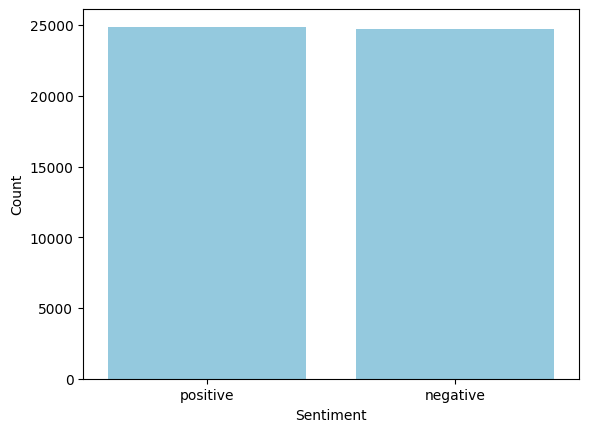

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [37]:
sentiment_values = df['sentiment'].value_counts()
sns.barplot(x=sentiment_values.index, y=sentiment_values.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
sentiment_values

In [41]:
stop_words = set(stopwords.words('english'))

In [44]:
def preprocess_text(text):
    try:
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\W', ' ', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    except Exception as e:
        raise

In [45]:
df['review'] = df['review'].apply(preprocess_text)

In [48]:
df[df.duplicated()]

,review,sentiment
17482,biggest fan westerns two personal favorites th...,positive
27528,yet another pseudo intellectual let make nazis...,negative
32051,opportunity watch filming slavic village broad...,positive
41322,imagine worst skits saturday night live mad tv...,negative
48097,tasty little frenchman tells story alternately...,positive


In [51]:
df.drop_duplicates(inplace=True)

# 2. Convert Text to Numerical Features

In [77]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['review'])

# 3. Apply Clustering Algorithms

### 3.1 Determine optimal clusters using the Elbow Method

In [79]:
wcss = []
k_range = range(2, 10)
for k in k_range:
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10)
    k_means.fit(X)
    wcss.append(k_means.inertia_)

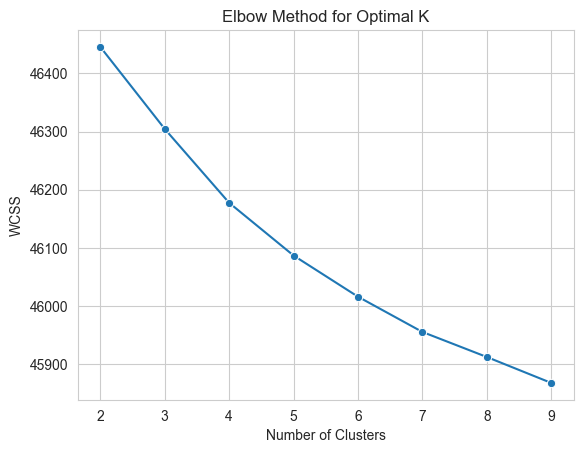

In [82]:
sns.set_style('whitegrid')
sns.lineplot(x=list(k_range), y=wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

### 3.2 Apply K-Means clustering


In [83]:
optimal_k = 5
k_means = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = k_means.fit_predict(X)
df['cluster'] = labels

In [84]:
df.head()

,review,sentiment,cluster
0,one reviewers mentioned watching oz episode ho...,positive,1
1,wonderful little production br br filming tech...,positive,2
2,thought wonderful way spend time hot summer we...,positive,2
3,basically family little boy jake thinks zombie...,negative,2
4,petter mattei love time money visually stunnin...,positive,2


In [85]:
df['cluster'].value_counts()

cluster
0    17185
2    14946
4     9057
3     6607
1     1782
Name: count, dtype: int64

### 3.3 Evaluate clustering using Silhouette Score

In [88]:
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.0013456280270563847


### 3.4 Reduce dimensions using PCA for visualization

In [119]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

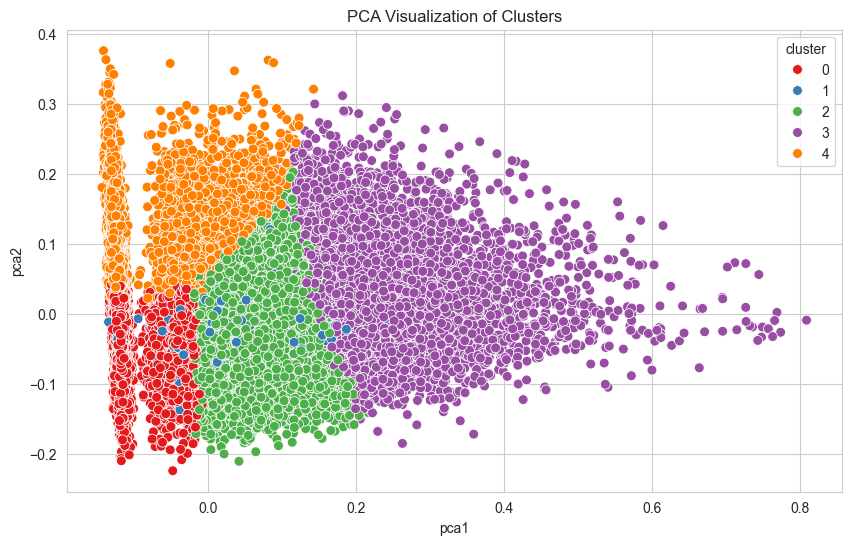

In [120]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1', s=50)
plt.title('PCA Visualization of Clusters')
plt.show()